<a href="https://colab.research.google.com/github/stranger9977/NFL_Metric_Analysis_Series/blob/main/touchdown_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
pip install nfl_data_py nflfastpy

In [81]:
import pandas as pd
import nfl_data_py as nfl
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

In [78]:
df = nfl.import_pbp_data([2015,2021])

2015 done.
2021 done.
Downcasting floats.


In [80]:
rushing_df_filters = (df['rush_attempt'] == 1) & (df['two_point_attempt'] == 0)
rushing_df = df.loc[rushing_df_filters, ['rush_attempt', 'rush_touchdown', 'yardline_100']]
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize=True)
rushing_df_probs = pd.DataFrame({
    'probability_of_touchdown': rushing_df_probs.values
}, index=rushing_df_probs.index).reset_index()
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1, ['yardline_100', 'probability_of_touchdown']]
rushing_df_probs.head()

,yardline_100,probability_of_touchdown
0,1.0,0.554080
3,2.0,0.426087
5,3.0,0.310680
7,4.0,0.300518
9,5.0,0.220096


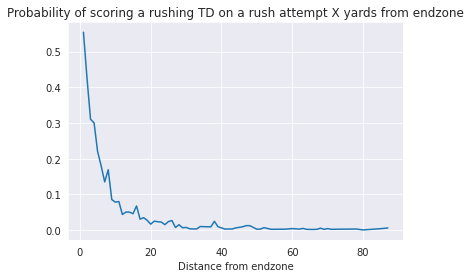

In [82]:
plt.plot(rushing_df_probs['yardline_100'], rushing_df_probs['probability_of_touchdown']);
plt.title('Probability of scoring a rushing TD on a rush attempt X yards from endzone');
plt.xlabel('Distance from endzone');

In [83]:
df_2021 = nfl.import_pbp_data([2021])

2021 done.
Downcasting floats.


In [84]:
roster_2021 = nfl.import_rosters([2022])
rbs = roster_2021.loc[roster_2021['position'] == 'RB']
rbs.head()

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,espn_id,sportradar_id,yahoo_id,rotowire_id,pff_id,pfr_id,fantasy_data_id,sleeper_id,years_exp,headshot_url
67,2022,ARI,RB,NaN,21,Active,TJ Pledger,TJ,Pledger,NaN,...,NaN,d607d750-d554-11ec-addb-6dd6dcd40f21,NaN,16618.0,NaN,NaN,NaN,8407,0.0,NaN
68,2022,ARI,RB,NaN,27,Active,Jaylen Samuels,Jaylen,Samuels,1996-07-20,...,3116721.0,fd4241f9-ab42-4dba-a701-455b896eca28,31135.0,12779.0,47297.0,SamuJa00,19996.0,5107,4.0,https://static.www.nfl.com/image/private/f_aut...
69,2022,ARI,RB,NaN,30,Active,Keaontay Ingram,Keaontay,Ingram,1999-10-26,...,NaN,9b212b70-ccc3-4c77-ba73-09afeb929225,NaN,15847.0,NaN,NaN,NaN,8221,0.0,NaN
70,2022,ARI,RB,RB,26,Active,Eno Benjamin,Eno,Benjamin,1999-04-13,...,4242873.0,aebf7b65-da15-4499-b1af-6687fa50b2e4,32892.0,14372.0,57136.0,BenjEn00,21773.0,6951,2.0,https://static.www.nfl.com/image/private/f_aut...
71,2022,ARI,RB,NaN,37,Active,Ronnie Rivers,Ronnie,Rivers,NaN,...,NaN,246db560-cb4e-11ec-a667-6354702e3fca,NaN,16108.0,NaN,NaN,NaN,8195,0.0,NaN


In [85]:
df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50712 entries, 0 to 50711
Data columns (total 372 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    play_id                               float32
 1    game_id                               object 
 2    old_game_id                           object 
 3    home_team                             object 
 4    away_team                             object 
 5    season_type                           object 
 6    week                                  int32  
 7    posteam                               object 
 8    posteam_type                          object 
 9    defteam                               object 
 10   side_of_field                         object 
 11   yardline_100                          float32
 12   game_date                             object 
 13   quarter_seconds_remaining             float32
 14   half_seconds_remaining                float32
 15   

In [86]:
#
rushing_df_2021 = df_2021.loc[df_2021['rush_attempt'] == 1, 
['rusher_id', 'rusher_player_name', 'rush_attempt','rush_touchdown', 'yardline_100']]
rushing_df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15164 entries, 2 to 50710
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rusher_id           14212 non-null  object 
 1   rusher_player_name  15164 non-null  object 
 2   rush_attempt        15164 non-null  float32
 3   rush_touchdown      15164 non-null  float32
 4   yardline_100        15164 non-null  float32
dtypes: float32(3), object(2)
memory usage: 533.1+ KB


In [87]:
rushing_df_2021 = rushing_df_2021.merge(rushing_df_probs, how='left', on='yardline_100')
rushing_df_2021 = rushing_df_2021.groupby('rusher_id', as_index=False).agg({
    'rusher_player_name': 'first', 'rush_touchdown': 'sum', 'probability_of_touchdown': 'sum'
}).rename({
    'probability_of_touchdown': 'expected_touchdowns', 'rush_touchdown': 'actual_touchdowns'
}, axis=1)
rushing_df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rusher_id            385 non-null    object 
 1   rusher_player_name   385 non-null    object 
 2   actual_touchdowns    385 non-null    float32
 3   expected_touchdowns  385 non-null    float64
dtypes: float32(1), float64(1), object(2)
memory usage: 10.7+ KB


In [88]:


rushing_df_2021['positive_regression_candidate'] = rushing_df_2021['actual_touchdowns'] < rushing_df_2021['expected_touchdowns']
rushing_df_2021['delta'] = rushing_df_2021.apply(lambda x: abs(x.expected_touchdowns - x.actual_touchdowns), axis=1)
rushing_df_2021.sort_values(by='expected_touchdowns', ascending=False).head()

,rusher_id,rusher_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
296,00-0036223,J.Taylor,18.0,16.559274,False,1.440726
154,00-0033897,J.Mixon,14.0,12.818062,False,1.181938
137,00-0033553,J.Conner,16.0,11.758515,False,4.241485
267,00-0035657,D.Harris,15.0,10.074120,False,4.925880
152,00-0033893,D.Cook,6.0,9.668548,True,3.668548


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


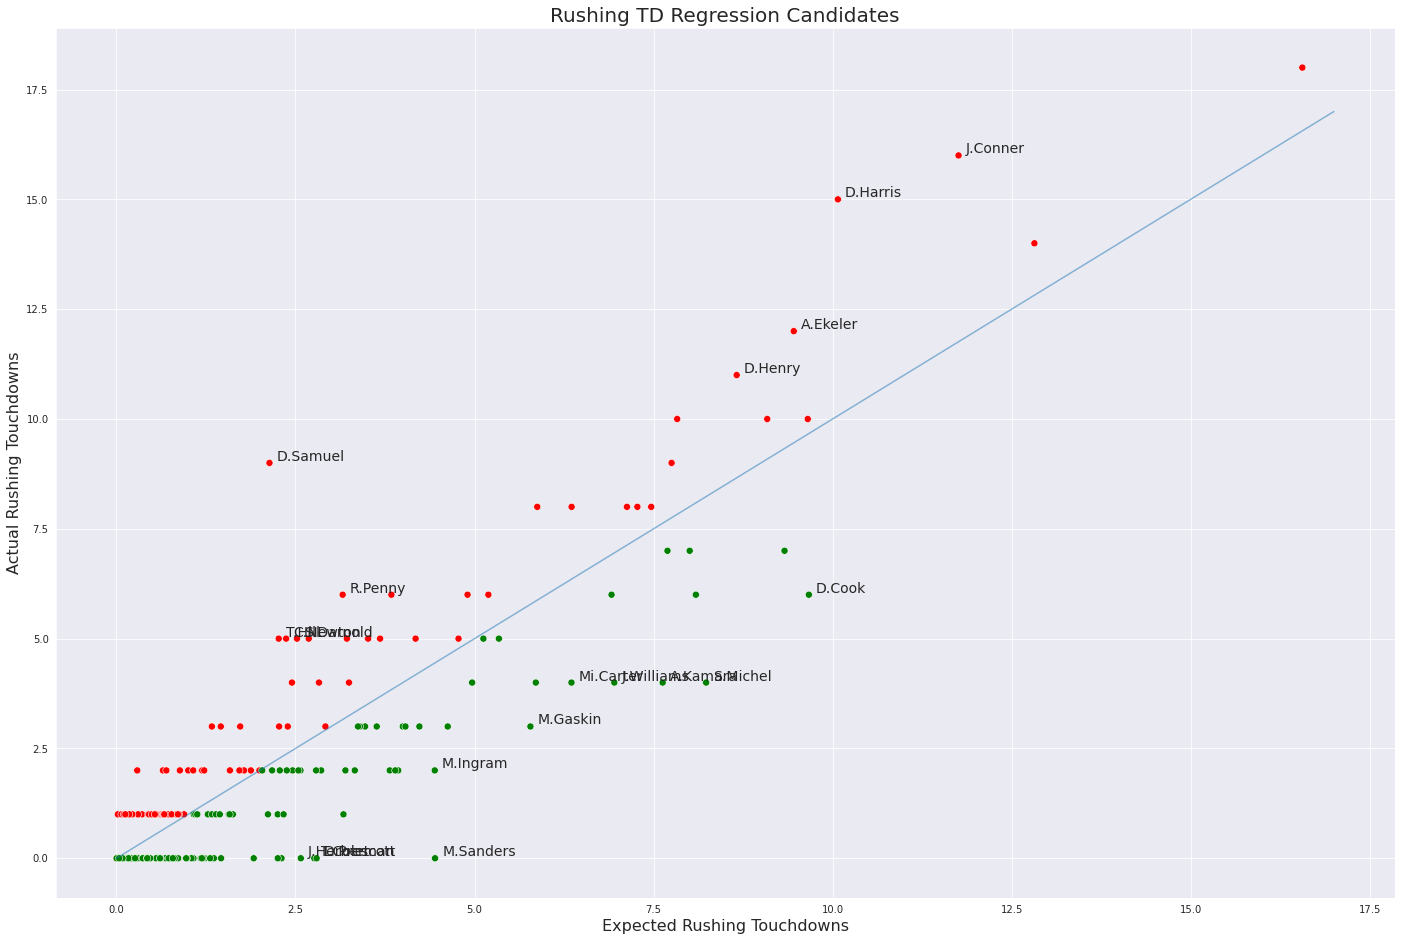

In [92]:
fig, ax = plt.subplots(figsize=(24, 16))
sns.scatterplot(
    x = 'expected_touchdowns',
    y = 'actual_touchdowns',
    hue = 'positive_regression_candidate',
    data = rushing_df_2021,
    palette = ['r', 'g'], # red and green,
    s=50
);

max_act_touchdowns = int(rushing_df_2021['actual_touchdowns'].max()) # max touchdowns
max_exp_touchdowns = int(rushing_df_2021['expected_touchdowns'].max()) # max expected touchdowns

max_tds = max(max_act_touchdowns, max_exp_touchdowns) # max of actual and expected tds

sns.lineplot(range(max_tds), range(max_tds), alpha=0.5); # plotting a line with slope of 1 up to max_tds number. This is the blue line on our viz

#15 players with the highest delta between expected and actual TDs (negative or positive)
top_x_delta = rushing_df_2021.sort_values(by='delta', ascending=False)[:20]

for _, row in top_x_delta.iterrows(): 
    ax.text(
        x = row['expected_touchdowns']+0.1, # add a bit of spacing from the point in the x-direction
        y = row['actual_touchdowns'] + .05, # same but in the y-direction
        s = row['rusher_player_name'], # annotate with the player's name,
        fontsize=14
    )
ax.get_legend().remove()
ax.set_title('Rushing TD Regression Candidates', fontsize=20)
ax.set_xlabel('Expected Rushing Touchdowns', fontsize=16)
ax.set_ylabel('Actual Rushing Touchdowns', fontsize=16);

In [99]:
top_x_delta.loc[top_x_delta['positive_regression_candidate'] == True].sort_values(by=['expected_touchdowns'], ascending=False)

,rusher_id,rusher_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
152,00-0033893,D.Cook,6.0,9.668548,True,3.668548
217,00-0034845,S.Michel,4.0,8.233840,True,4.233840
155,00-0033906,A.Kamara,4.0,7.626852,True,3.626852
380,00-0036997,J.Williams,4.0,6.951957,True,2.951957
368,00-0036924,Mi.Carter,4.0,6.353725,True,2.353725
248,00-0035311,M.Gaskin,3.0,5.780714,True,2.780714
239,00-0035243,M.Sanders,0.0,4.448675,True,4.448675
20,00-0027966,M.Ingram,2.0,4.444691,True,2.444691
114,00-0033077,D.Prescott,0.0,2.795254,True,2.795254
73,00-0032058,T.Coleman,0.0,2.762276,True,2.762276
